# 3. Instrument Beam, Instrument Noise, and Filtering
### Original from Jeff McMahon and Renée Hložek 

We will now add noise and filter the map - so that we have a map with all astrophysical and instrumental effects.

In [4]:
import os
import sys
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
from constants import *
from cmb_modules import *

In [6]:
data = './data/'
out = './output/'

### Just some matplotlib and seaborn parameter tuning

In [7]:
# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## Recalculating the results from the previous stages

In [8]:
## Create a pure CMB map
# Read in the input CMB spectra
data = np.genfromtxt(data + 'CAMB_fiducial_cosmo_scalCls.dat',)
ell = data[:,0]
DlTT = data[:,1]
ell_err = data[:,2]
DlTT_err = data[:,3]

CMB_I, ell2d, ClTT2d, FT_2d = make_CMB_I_map(ell, DlTT, N_x=N_x, N_y=N_y,
                                             X_width=X_width, Y_width=Y_width, pix_size=pix_size,
                                             random_seed=42)

# Make a point source map by generating Poisson distributed background and
# adding the exponentially distributed sources over that
PSmap_p = poisson_source_component(N_x, N_y, pix_size, number_of_sources, amplitude_of_sources)
PSmap_e = exponential_source_component(N_x, N_y, pix_size, number_of_sources_EX, amplitude_of_sources_EX)
PSmap = PSmap_p + PSmap_e

# Make an SZ map
SZmap, SZcat, beta = SZ_source_component(N_x, N_y,
                                         X_width, Y_width, pix_size,
                                         number_of_SZ_clusters, mean_amplitude_of_SZ_clusters, SZ_beta, SZ_theta_core)

# Add them all together to get the sky map at a single freuqency
total_map = CMB_I + PSmap + SZmap

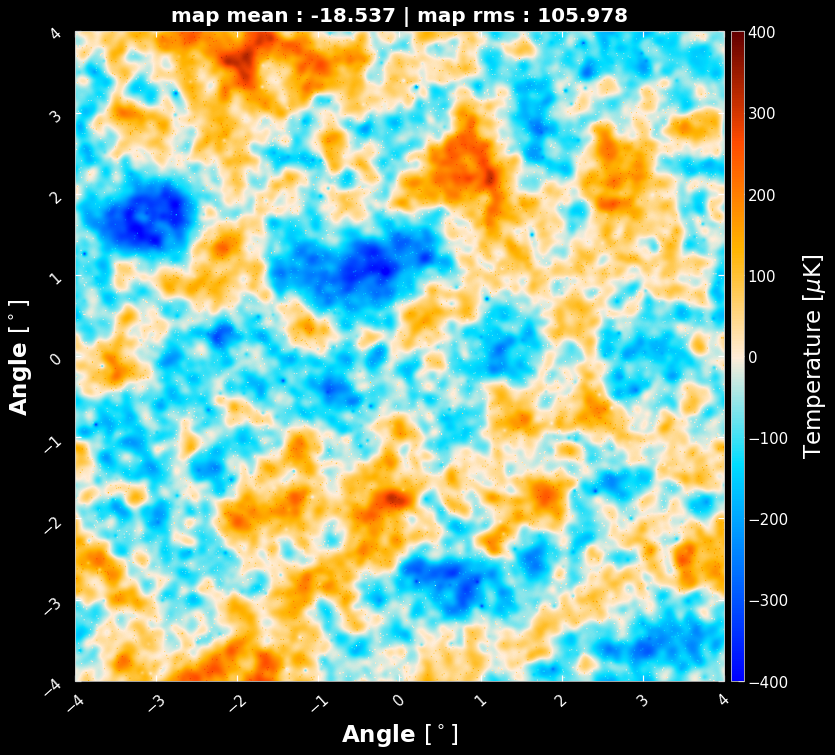

In [9]:
plot_CMB_map(total_map, X_width, Y_width, c_min=c_min, c_max=c_max,
             save=False, no_axis=False, no_grid=True)

## Sky Map Convolved with a Beam

Telescopes suffer from diffraction which leads to finite resolution effects.  To account for this we generate a Gaussian beam pattern and convolve the map with it.

In [10]:
beam_size_fwhp = 1.25

In [11]:
def make_2d_gaussian_beam(N_x=2**10, N_y=2**10//2,
                          beam_size_fwhp=1.25):
    """
    Creates a 2D Gaussian function.
    
    Paramters
    ---------
    N_x : int
        Number of pixels in the linear dimension along the X-axis.
    N_y : int
        Number of pixels in the linear dimension along the Y-axis.
    beam_size_fwhp : float
        Mean FWHM of the simulated beam.
    
    Returns
    -------
    gaussian : numpy.ndarray of shape (N_x, N_y)
        The 2D Gaussian function over the input domain.
    """
    # Calculate distances to the center of the image on the map
    R = make_coordinates(N_x, N_y,
                         X_width, Y_width,
                         absolute=True)

    ## Make a 2D Gaussian 
    # Planck's beam sigma values are approximately similar to this in magnitude
    beam_sigma = beam_size_fwhp / np.sqrt(8 * np.log(2))
    gaussian = np.exp(-0.5 * (R/beam_sigma)**2)
    gaussian = gaussian / np.sum(gaussian)

    return gaussian

In [12]:
def convolve_map_with_gaussian_beam(Map,
                                    N_x=2**10, N_y=2**10//2,
                                    beam_size_fwhp=1.25):
    """
    Convolves a map with a Gaussian beam pattern.
    
    Paramters
    ---------
    Map : numpy.ndarray of shape (N_x, N_y)
        The input map to be convolved with the generated Gaussian.
    N_x : int
        Number of pixels in the linear dimension along the X-axis.
    N_y : int
        Number of pixels in the linear dimension along the Y-axis.
    beam_size_fwhp : float
        Mean FWHM of the simulated beam.
    
    Returns
    -------
    convolved_map : numpy.ndarray of shape (N_x, N_y)
        The beam convolved with the input map.
    """ 
    # make a 2d gaussian 
    gaussian = make_2d_gaussian_beam(N_x, N_y,
                                     beam_size_fwhp)
  
    ## Do the convolution
    # 1. First add the shift so that it is central
    FT_gaussian = np.fft.fft2(np.fft.fftshift(gaussian))
    # 2. Shift the map too
    FT_map = np.fft.fft2(np.fft.fftshift(Map))
    convolved_map = np.fft.fftshift(np.real(np.fft.ifft2(FT_gaussian*FT_map))) 
    
    return convolved_map

In [13]:
# Convolve the signal part of the map
CMB_I_convolved = convolve_map_with_gaussian_beam(total_map,
                                                  N_x, N_y,
                                                  beam_size_fwhp=beam_size_fwhp)

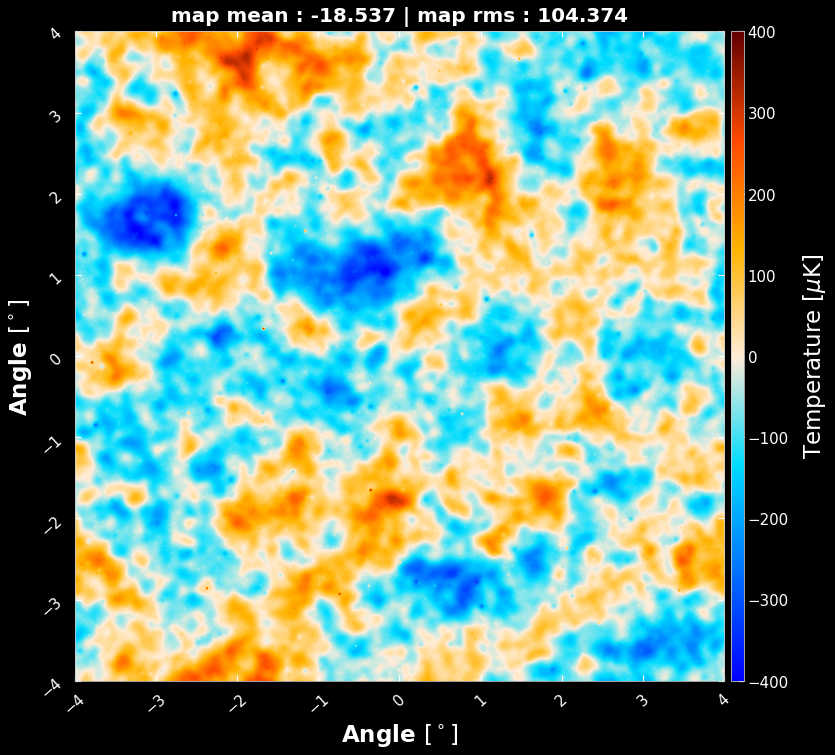

In [14]:
plot_CMB_map(CMB_I_convolved, X_width, Y_width, c_min=c_min, c_max=c_max,
             save=False, no_axis=False, no_grid=True)

This plot shows the simulated map that includes the CMB, point source, and SZ signals and is convolved with an instrumental beam.  The agreement with the real sky maps is now reasonable, but does not yet include instrumental noise.

<font color='red'>ORIGINAL NOTES: </font> There are three typical beam sizes for CMB experiments: 1) large anguar scale B-mode observatories which have ~30 arcminute beams; 2) medium scale observatorires such as the Planck satellite that has a ~3 arcminute beam, and 3) high resolution observatories such as ACT and SPT that have ~1 arcminute beams.

### Compare different beam FWHM values

#### FWHM = 30 arcmin

In [15]:
# Convolve the signal part of the map
CMB_I_convolved = convolve_map_with_gaussian_beam(total_map,
                                                  N_x, N_y,
                                                  beam_size_fwhp=30)

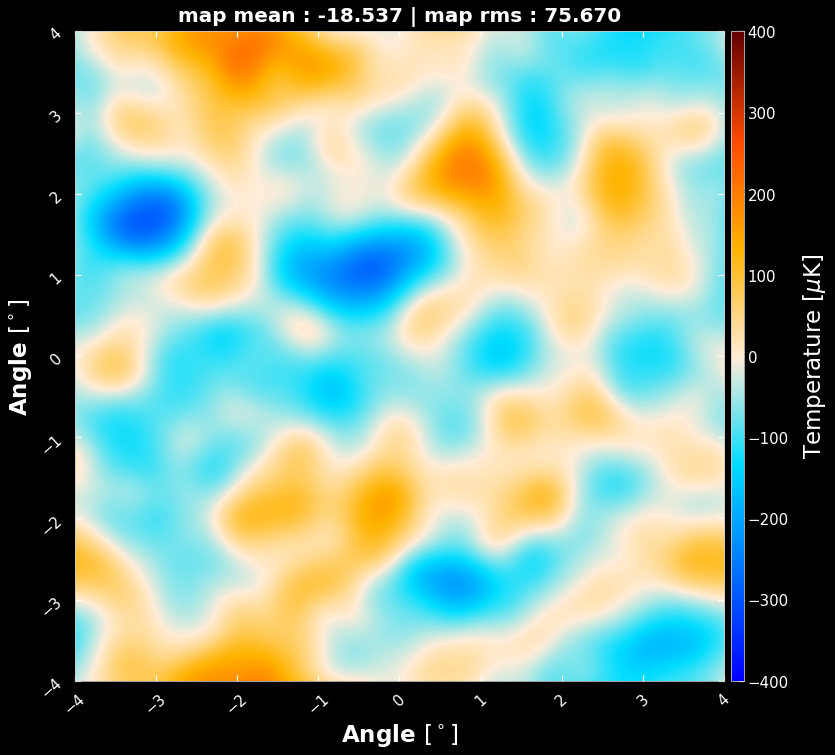

In [16]:
plot_CMB_map(CMB_I_convolved, X_width, Y_width, c_min=c_min, c_max=c_max,
             save=False, no_axis=False, no_grid=True)

#### FWHM = 3 arcmin

In [17]:
# Convolve the signal part of the map
CMB_I_convolved = convolve_map_with_gaussian_beam(total_map,
                                                  N_x, N_y,
                                                  beam_size_fwhp=3)

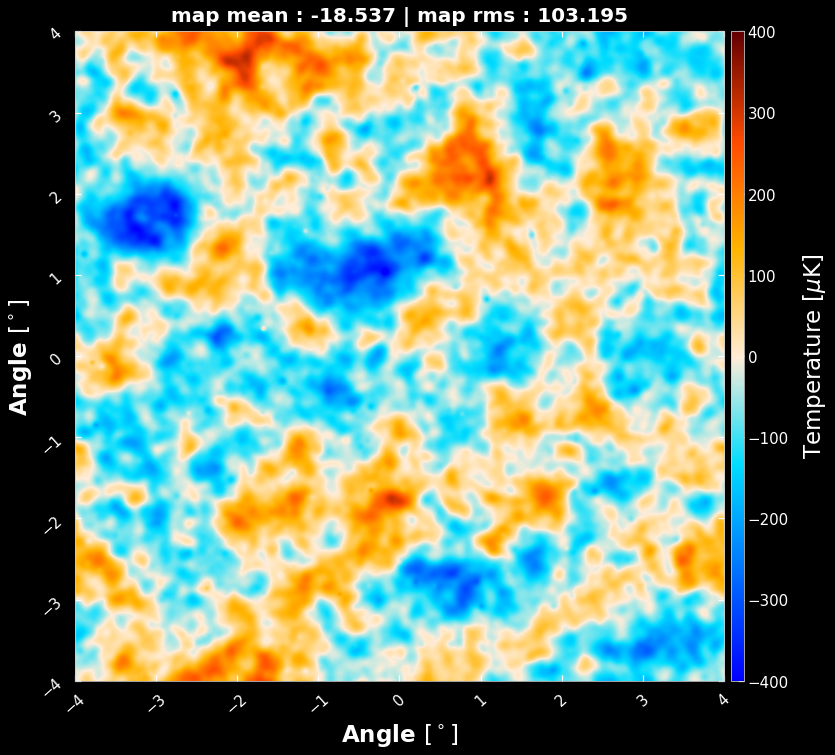

In [18]:
plot_CMB_map(CMB_I_convolved, X_width, Y_width, c_min=c_min, c_max=c_max,
             save=False, no_axis=False, no_grid=True)

#### FWHM = 0.5 arcmin

In [19]:
# Convolve the signal part of the map
CMB_I_convolved = convolve_map_with_gaussian_beam(total_map,
                                                  N_x, N_y,
                                                  beam_size_fwhp=0.5)

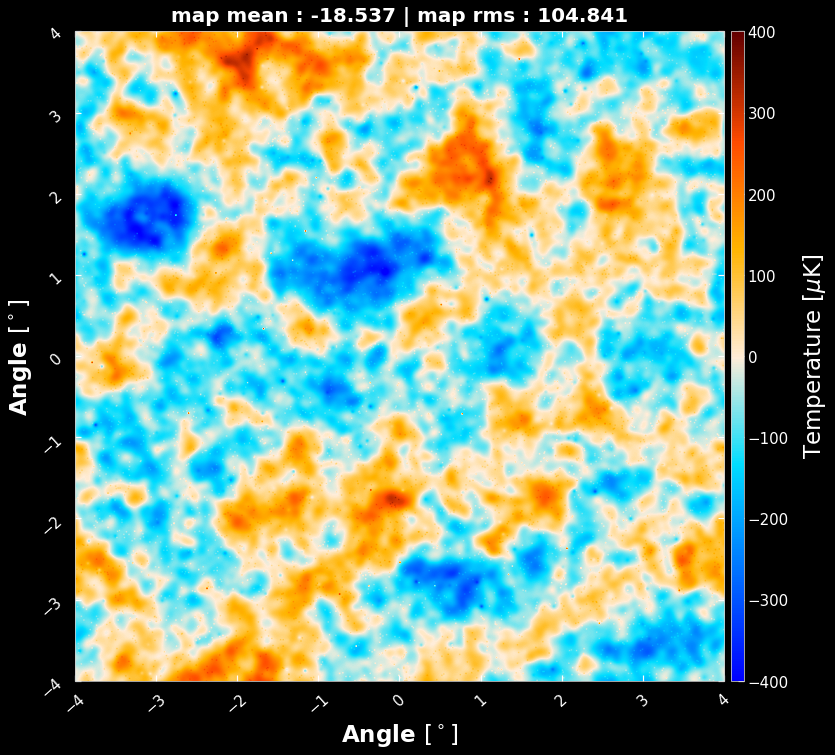

In [20]:
plot_CMB_map(CMB_I_convolved, X_width, Y_width, c_min=c_min, c_max=c_max,
             save=False, no_axis=False, no_grid=True)

## Noise Map

Ground based CMB instruments suffer from several types of noise.  This includes: (1) White noise drawn from a gaussian distribution; (2) atmospheric noise which grows larger on large angular scales, this can be understood in terms of Kolmogorov turbulence; and (3) $1/f$ noise in the detectors.  Both atmospheric and detector $1/f$ manifest as correlated noise in maps space.  However, like the CMB these noise components are very nearly uncorrelated in Fourier space.  We will build these noise terms in Fourier space and display them in map space. 

We choose a white noise level of 10 $\mu$K-arcmin to approximate the current deep maps coming from ACTPol and SPTPol.  The $1/f$ noise is similar to what would be seen in an experiment at the south pole.  When turned on, this noise leads to the effect of "striping" in the maps.  We default to turning this component off since if it is included we would need to filter the maps before estimating the power spectrum.  (This is easy, but is not yet implemented).  The atmospheric noise (Kolmogorov turbulence) has a 2D spectrum similar to CMB leading to similar patterns in the maps.

In [21]:
white_noise_level = 10         # White noise [micro K/arcmin]
atmospheric_noise_level = 0.1  # Multiply by zero to turn this off
one_over_f_noise_level = 0.2   # Multiply by zero to turn this off

In [22]:
def gen_white_noise(N_x, N_y,
                    pix_size,
                    white_noise_level):
    """
    Makes a white noise map.
    
    Parameters
    ----------
    N_x : int
        Number of pixels in the linear dimension along the X-axis.
    N_y : int
        Number of pixels in the linear dimension along the Y-axis.
    pix_size : float
        Size of a pixel in arcminutes.
    white_noise_level : float
    
    Returns
    -------
    white_noise : numpy.ndarray of shape (N_x, N_y)
        The white noise map.
    """
    white_noise = np.random.normal(0,1,(N_x,N_y)) * white_noise_level/pix_size
    
    return white_noise

In [23]:
def gen_atmospheric_noise(N_x, N_y,
                          X_width, Y_width, pix_size,
                          atmospheric_noise_level):
    """
    Makes an atmospheric noise map.
    
    Parameters
    ----------
    N_x : int
        Number of pixels in the linear dimension along the X-axis.
    N_y : int
        Number of pixels in the linear dimension along the Y-axis.
    X_width : float
        Size of the map along the X-axis in degrees.
    Y_width : float
        Size of the map along the Y-axis in degrees.
    pix_size : float
        Size of a pixel in arcminutes.
    atmospheric_noise_level : float
    
    Returns
    -------
    atmospheric_noise : numpy.ndarray of shape (N_x, N_y)
        The atmospheric noise map.
    """
    # Calculate distances to the center of the image on the map
    R = make_coordinates(N_x, N_y,
                         X_width, Y_width,
                         absolute=True)
    # Convert distances in arcmin to degrees
    R /= 60
    mag_k = 2 * np.pi/(R + 0.01)  # 0.01 is a regularization factor
    atmospheric_noise = np.fft.fft2(np.random.normal(0,1,(N_x,N_y)))
    atmospheric_noise  = np.fft.ifft2(atmospheric_noise * np.fft.fftshift(mag_k**(5/3)))
    atmospheric_noise = atmospheric_noise * atmospheric_noise_level/pix_size
    
    return atmospheric_noise

In [29]:
def gen_one_over_f_noise(N_x,
                         pix_size,
                         one_over_f_noise_level):
    """
    Generates 1/f noise in the X direction.
    
    Parameters
    ----------
    N_x : int
        Number of pixels in the linear dimension along the X-axis.
    pix_size : float
        Size of a pixel in arcminutes.
    one_over_f_noise_level : float
    
    Returns
    -------
    one_over_f_noise : numpy.ndarray of shape (N_x, N_y)
        The 1/f noise map along the X direction.
    """
    ones = np.ones(N_x)
    inds  = (np.arange(N_x)+0.5 - N_x/2)
    X = np.outer(ones,inds) * pix_size / 60  # [degrees]
    kx = 2 * np.pi/(X+0.01)                  # 0.01 is a regularization factor
    one_over_f_noise = np.fft.fft2(np.random.normal(0,1,(N_x,N_y)))
    one_over_f_noise = np.fft.ifft2(one_over_f_noise * np.fft.fftshift(kx)) * one_over_f_noise_level/pix_size
    
    return one_over_f_noise

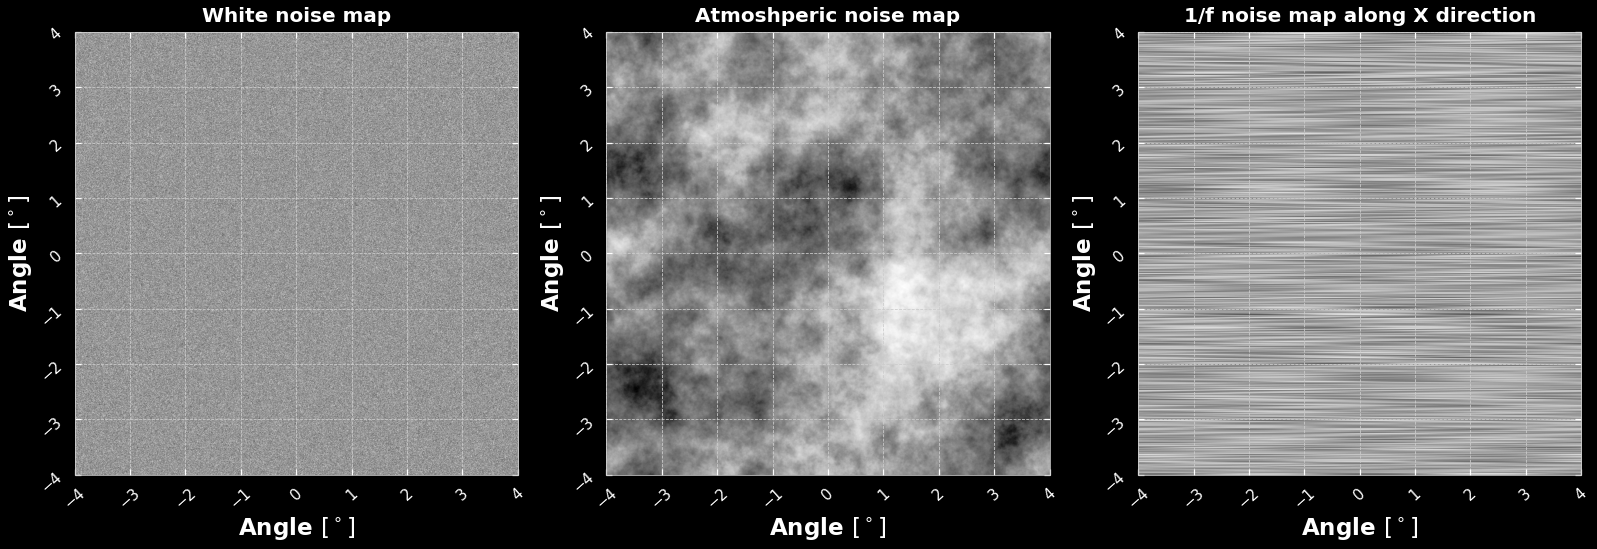

In [33]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*9, nrows*9),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

noises = [
    gen_white_noise(N_x, N_y, pix_size, white_noise_level),       # White noise
    gen_atmospheric_noise(N_x, N_y, X_width, Y_width, pix_size,
                          atmospheric_noise_level),               # Atmoshperic noise
    gen_one_over_f_noise(N_x, pix_size, one_over_f_noise_level)   # 1/f noise
]
noises_titles = [
    'White noise map',
    'Atmoshperic noise map',
    '1/f noise map along X direction',
]

for i in range(ncols):
    ax = axes[i]
    im = ax.imshow(np.real(noises[i]), cmap='Greys_r')
    im.set_extent([-X_width/2,X_width/2, -Y_width/2,Y_width/2])
    
    ax.set_title(noises_titles[i],
                 color='white', fontsize=axistitlesize, fontweight='bold', pad=10)
    ax.set_xlabel('Angle $[^\circ]$', color='white', fontsize=axislabelsize, fontweight='bold')
    ax.set_ylabel('Angle $[^\circ]$', color='white', fontsize=axislabelsize, fontweight='bold')
    ax.tick_params(axis='both', which='major', colors='white', labelsize=axisticksize, labelrotation=42, pad=10)

plt.show()

In [2]:
def make_noise_map(N_x, N_y,
                   X_width, Y_width, pix_size,
                   white_noise_level=10,
                   atmospheric_noise_level=0.1, one_over_f_noise_level=0.2):
    """
    Makes a realization of instrument noise, atmosphere and :math:`1/f`
    noise level set at 1 degrees.
    
    Parameters
    ----------
    
    Returns
    -------
    """
    
    # Make a white noise map
    white_noise = gen_white_noise(N_x, N_y,
                                 pix_size,
                                 white_noise_level)
 
    # Make an atmosperhic noise map
    atmospheric_noise = 0
    if (atmospheric_noise_level != 0):
        atmospheric_noise = gen_atmospheric_noise(N_x, N_y,
                                                  X_width, Y_width, pix_size,
                                                  atmospheric_noise_level)

    # Make a 1/f map, along a single direction to illustrate striping 
    one_over_f_noise = 0
    if (one_over_f_noise_level != 0): 
        one_over_f_noise = gen_one_over_f_noise(N_x,
                                                pix_size,
                                                one_over_f_noise_level)

    noise_map = np.real(white_noise + atmospheric_noise + one_over_f_noise)
    return noise_map

In [35]:
## make an instrument noise map
noise = make_noise_map(N_x, N_y,
                       X_width, Y_width, pix_size,
                       white_noise_level,
                       atmospheric_noise_level, one_over_f_noise_level)

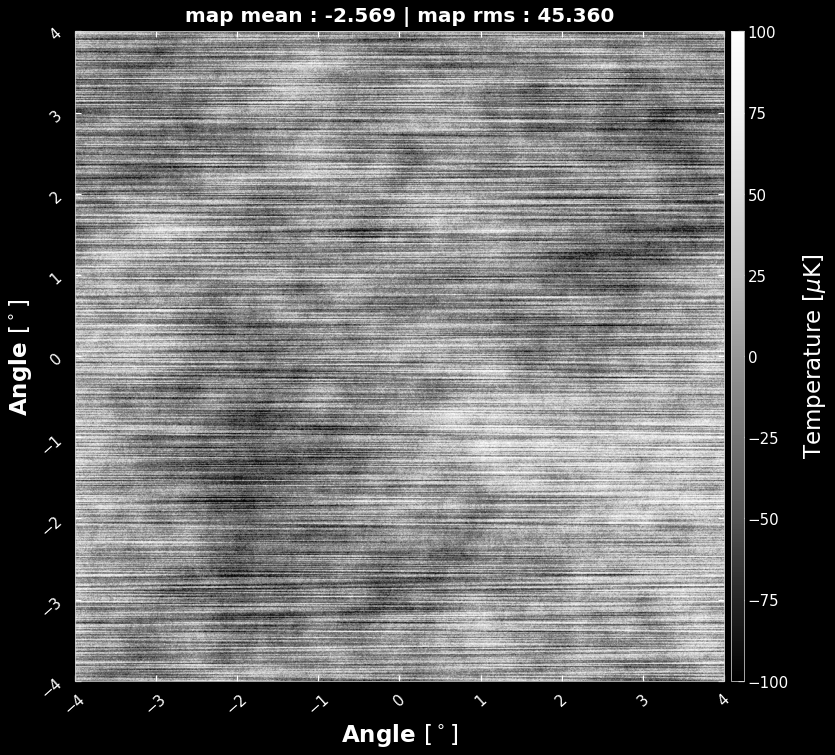

In [36]:
plot_CMB_map(noise, X_width, Y_width, c_min=c_min/4, c_max=c_max/4,
             cmap = 'Greys_r',
             save=False, no_axis=False, no_grid=True)

This plot shows a realization of instrumental + atmospheric noise.  The atmospheric noise looks similar to the CMB since it has a similar 2d spectrum.  

## Complete Simulated CMB Map

We complete our simulated CMB map by adding the simulated sky map convolved with the beam to our simulated noise map.   

In [42]:
# Add noise to the signal
total_map_plus_noise = CMB_I_convolved + noise

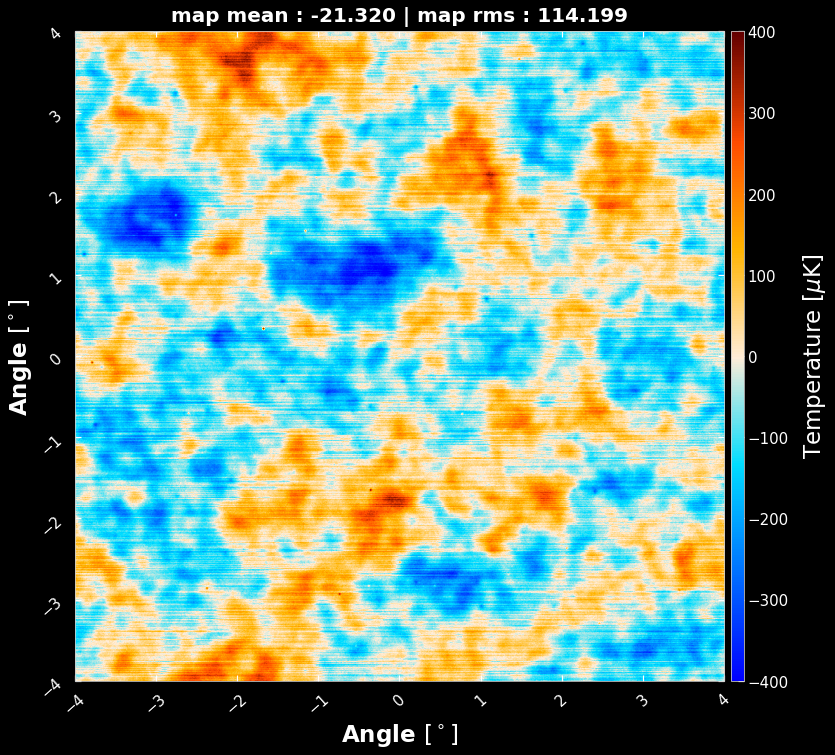

In [43]:
plot_CMB_map(total_map_plus_noise, X_width, Y_width, c_min=c_min, c_max=c_max,
             save=False, no_axis=False, no_grid=True)

This plot shows a complete simulated CMB map including the key astrophysical and instrumental effects.